### Model równoległy Conv 1D / RNN dla Zero Crossing Rate + RMS Energy

#### Architektura zawartego w tym notebooku modelu łączy dwie popularne ścieżki przetwarzania sygnałów audio: jednowymiarowe warstwy konwolucyjne (Conv 1D) i sieci rekurencyjne (RNN). Obie sieci działają równolegle. Wejściem dla modelu są cechy ZCR i RMS Energy obliczone dla każdej ramki czasowej sygnału audio. 

Etapy tworzenia modelu:

1. Przetworzenie danych wejściowych:

- Ekstrakcja cech Zero Crossing Rate (ZCR) i RMS Energy z plików audio:  
<ins> Zero Crossing Rate (ZCR) </ins> mierzy, jak często amplituda sygnału przechodzi z wartości dodatniej na ujemną lub z ujemnej na dodatnią. Określa liczbę przejść przez zero na jednostkę czasu, zazwyczaj na ramkę analizy. Na przykład wyższa wartość ZCR wskazuje na dźwięki wysokoczęstotliwościowe (np. syczące spółgłoski 's', 'f'), natomiast niższa wartość jest charakterystyczna dla dźwięków niskoczęstotliwościowych (np. samogłoski).  
<ins> RMS Energy </ins> to miara mocy lub głośności sygnału audio. Oblicza się ją jako pierwiastek kwadratowy ze średniej kwadratów amplitud sygnału w analizowanej ramce czasowej. Wyższa wartość wskazuje na głośniejszy dźwięk, niższa wartość na cichszy dźwięk lub ciszę.  
- Normalizacja i ujednolicenie długości sekwencji cech.


2. Budowa równoległej architektury:
- Ścieżka Conv1D wyodrębnia lokalne wzorce i cechy z sekwencji ZCR i RMS Energy, wykrywając krótkoterminowe zależności i charakterystyczne wzorce energii/przejść przez zero.
- Ścieżka RNN dobrze radzi sobie z modelowaniem długoterminowych zależności czasowych i kontekstu w sekwencjach ZCR i RMS Energy, co jest kluczowe dla rozpoznawania wzorców akustycznych.
- Obie ścieżki łączą się po ekstrakcji cech.

3. Implementacja funkcji pomocniczych:

- Wizualizacja wyników treningu, macierzy pomyłek.
- Obliczenie metryk klasyfikacji.
- Zapisanie modelu i mapowanie etykiet.


Przedstawiona architektura pozwala na równoległe przetwarzanie różnych rodzajów cech akustycznych, co może wpłynąć na otrzymanie lepszych wyników dla rozpoznawania emocji, ponieważ:

- Conv1D dobrze radzi sobie z lokalnymi wzorcami w sygnale (np. charakterystyczne częstotliwości przejść dla różnych emocji).
- BiLSTM potrafi uchwycić długoterminowe zależności i dynamiczne zmiany w energii sygnału.

### Import bibliotek

In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import random
import json

# Klasyfikacja ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


# Wizualizacja
import seaborn as sns

### Wczytanie zbioru nEMO

In [3]:
dataset = load_dataset("amu-cai/nEMO", split="train")

### Zastosowanie augmentacji plików audio

In [6]:
def add_noise(audio, noise_factor=0.005):
    """Dodaje biały szum do audio."""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_stretch(audio, rate=None):
    """Rozciąga czas (przyspiesza lub spowalnia) audio."""
    if rate is None:
        # Losowy współczynnik między 0.85 a 1.15
        rate = np.random.uniform(0.85, 1.15)
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps=None):
    """Zmienia wysokość tonu audio."""
    if n_steps is None:
        # Losowa zmiana tonu w zakresie od -2 do 2 półtonów
        n_steps = np.random.uniform(-2, 2)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def change_volume(audio, volume_factor=None):
    """Zmienia głośność audio."""
    if volume_factor is None:
        # Losowy współczynnik głośności między 0.8 a 1.2
        volume_factor = np.random.uniform(0.8, 1.2)
    return audio * volume_factor

def apply_augmentation(audio, sr, augment_prob=0.5):
    """Aplikuje losowe augmentacje z określonym prawdopodobieństwem."""
    augmented = np.copy(audio)
    
    # Dodaj szum
    if random.random() < augment_prob:
        augmented = add_noise(augmented, noise_factor=random.uniform(0.001, 0.01))
    
    # Rozciągnij czas
    if random.random() < augment_prob:
        augmented = time_stretch(augmented)
    
    # Zmień wysokość tonu
    if random.random() < augment_prob:
        augmented = pitch_shift(augmented, sr)
    
    # Zmień głośność
    if random.random() < augment_prob:
        augmented = change_volume(augmented)
    
    return augmented

Dodane techniki augmentacji:

- Dodawanie szumu - Symuluje różne warunki nagrywania, zwiększając odporność modelu na zakłócenia.
- Zmiana tempa (time stretching) - Zmienia tempo audio bez zmiany wysokości tonu.
- Zmiana wysokości tonu (pitch shifting) - Zmienia ton audio bez zmiany tempa.
- Zmiana głośności - Symuluje różne odległości od mikrofonu.

Korzyści z augmentacji danych:

- Zwiększona ilość danych treningowych - Każda próbka audio jest augmentowana 2-krotnie, co trzykrotnie zwiększa rozmiar zbioru treningowego.
- Lepsza generalizacja - Model będzie odporniejszy na różne warunki nagrywania i różnice w mówieniu.
- Redukcja przeuczenia - Większa różnorodność danych pomaga modelowi skupić się na istotnych cechach, a nie na szumach specyficznych dla danego nagrania.
- Zrównoważenie klas - Augmentacja może częściowo pomóc w problemie niezrównoważenia klas.

Dodatkowo, kod zawiera funkcję wizualizacji efektów augmentacji, która pomaga zobaczyć, jak różne techniki wpływają na sygnał audio i ekstrahowane cechy (ZCR i RMS Energy).
Augmentacja danych jest szczególnie ważna w przypadku rozpoznawania emocji z głosu, ponieważ ten sam tekst wypowiedziany z tą samą emocją może brzmieć zupełnie inaczej u różnych osób lub w różnych warunkach nagrywania. Dzięki augmentacji uczymy model rozpoznawać wzorce emocji niezależnie od tych zmiennych czynników.

### Wizualizacja efektów augmentacji

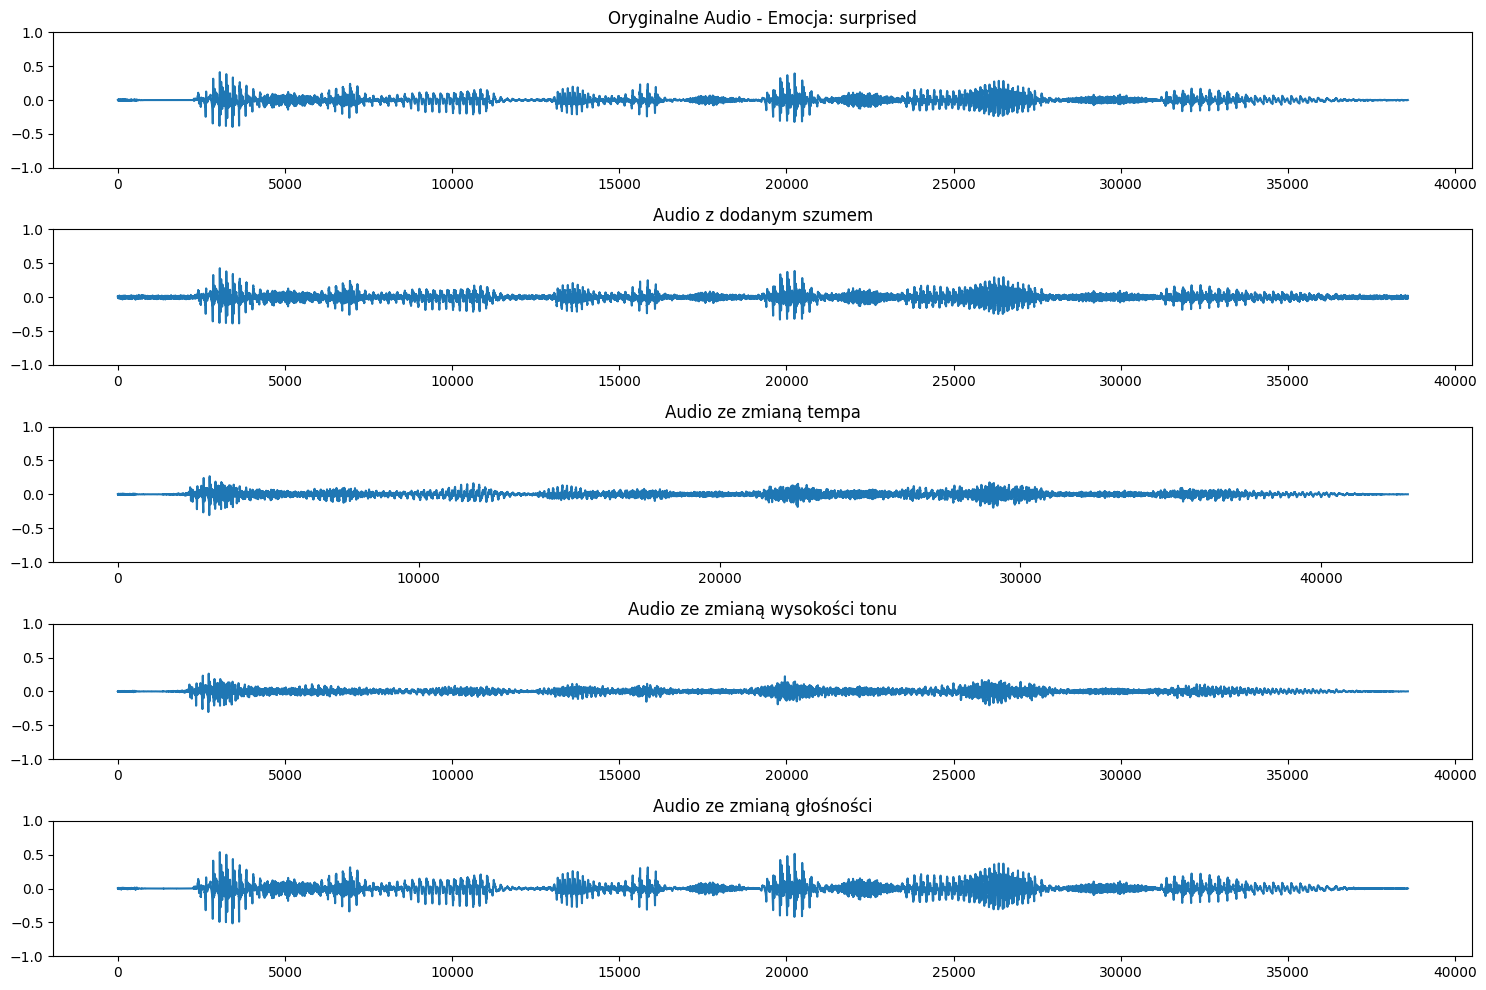

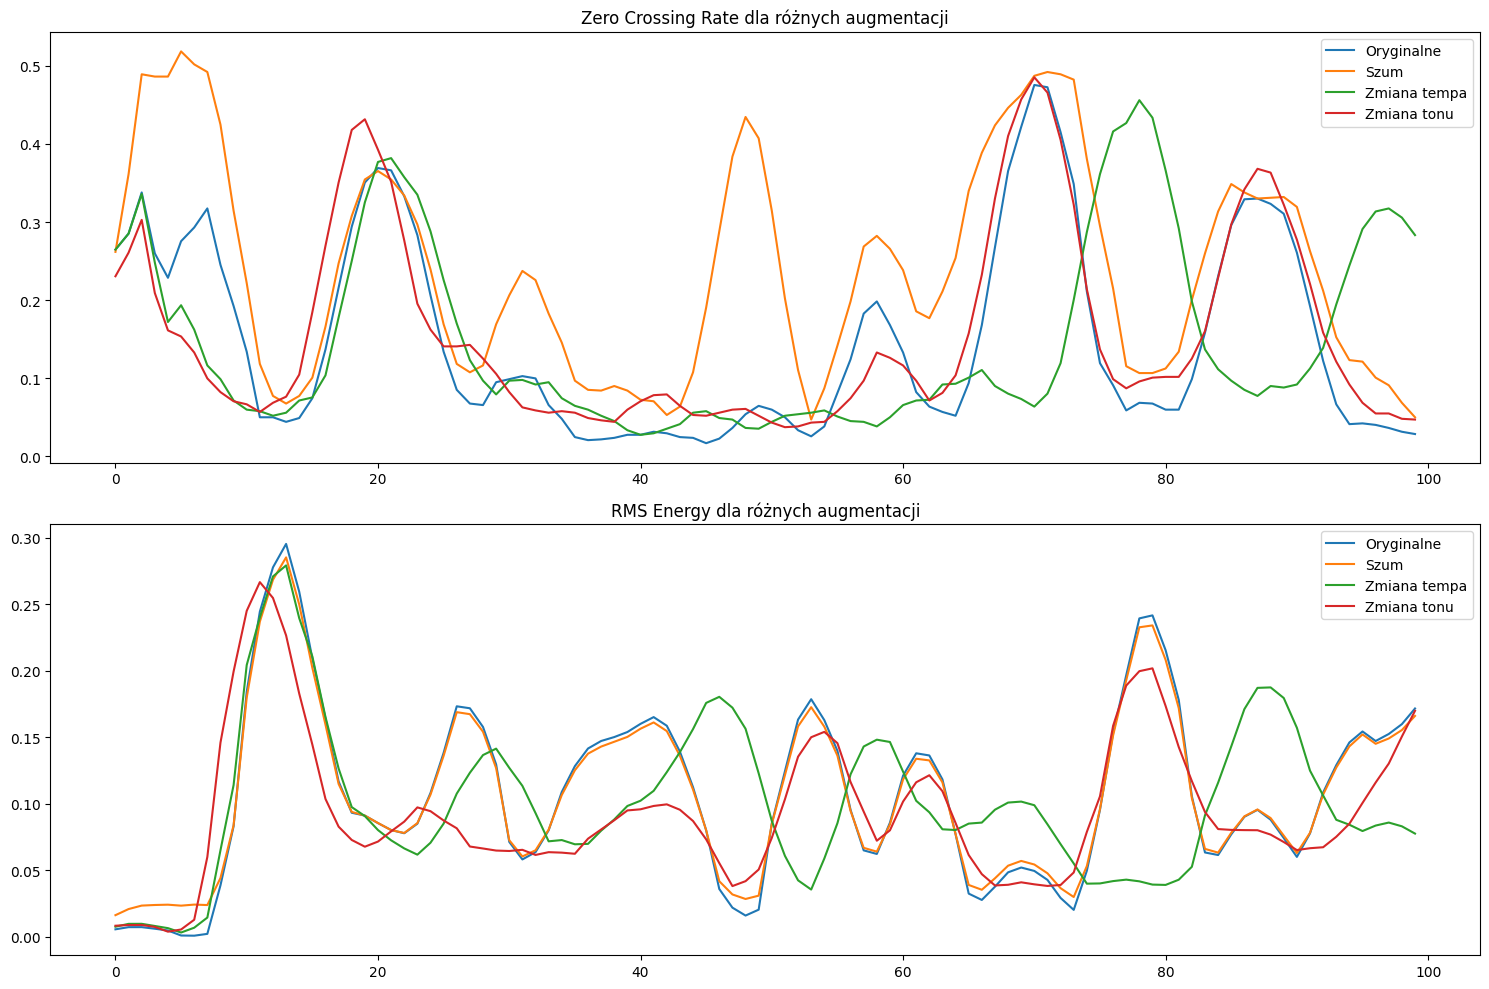

In [9]:
def visualize_augmentation_effects():
    # Wybierz przykładowe audio
    sample_idx = np.random.randint(0, len(audio_files))
    original_audio = audio_files[sample_idx]
    sr = sample_rates[sample_idx]
    emotion = labels[sample_idx]
    
    # Przycinanie do stałej długości
    max_len = 3 * sr  # 3 sekundy
    if len(original_audio) > max_len:
        original_audio = original_audio[:max_len]
    
    # Zastosuj różne augmentacje
    noisy_audio = add_noise(original_audio, noise_factor=0.01)
    stretched_audio = time_stretch(original_audio, rate=0.9)
    pitched_audio = pitch_shift(original_audio, sr, n_steps=2)
    volume_audio = change_volume(original_audio, volume_factor=1.3)
    
    # Wizualizacja przebiegów czasowych
    plt.figure(figsize=(15, 10))
    
    plt.subplot(5, 1, 1)
    plt.plot(original_audio)
    plt.title(f'Oryginalne Audio - Emocja: {emotion}')
    plt.ylim(-1, 1)
    
    plt.subplot(5, 1, 2)
    plt.plot(noisy_audio)
    plt.title('Audio z dodanym szumem')
    plt.ylim(-1, 1)
    
    plt.subplot(5, 1, 3)
    plt.plot(stretched_audio)
    plt.title('Audio ze zmianą tempa')
    plt.ylim(-1, 1)
    
    plt.subplot(5, 1, 4)
    plt.plot(pitched_audio)
    plt.title('Audio ze zmianą wysokości tonu')
    plt.ylim(-1, 1)
    
    plt.subplot(5, 1, 5)
    plt.plot(volume_audio)
    plt.title('Audio ze zmianą głośności')
    plt.ylim(-1, 1)
    
    plt.tight_layout()
    plt.savefig('augmentation_examples.png')
    plt.show()
    
    # Wizualizacja cech ZCR i RMS
    plt.figure(figsize=(15, 10))
    
    # Oryginalne cechy
    zcr_orig, rms_orig = extract_audio_features(original_audio, sr)
    zcr_noise, rms_noise = extract_audio_features(noisy_audio, sr)
    zcr_stretch, rms_stretch = extract_audio_features(stretched_audio, sr)
    zcr_pitch, rms_pitch = extract_audio_features(pitched_audio, sr)
    
    # Rysowanie ZCR
    plt.subplot(2, 1, 1)
    plt.plot(zcr_orig[:100], label='Oryginalne')
    plt.plot(zcr_noise[:100], label='Szum')
    plt.plot(zcr_stretch[:100], label='Zmiana tempa')
    plt.plot(zcr_pitch[:100], label='Zmiana tonu')
    plt.title('Zero Crossing Rate dla różnych augmentacji')
    plt.legend()
    
    # Rysowanie RMS
    plt.subplot(2, 1, 2)
    plt.plot(rms_orig[:100], label='Oryginalne')
    plt.plot(rms_noise[:100], label='Szum')
    plt.plot(rms_stretch[:100], label='Zmiana tempa')
    plt.plot(rms_pitch[:100], label='Zmiana tonu')
    plt.title('RMS Energy dla różnych augmentacji')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('feature_augmentation_examples.png')
    plt.show()

# Wywołaj funkcję wizualizacji augmentacji
try:
    visualize_augmentation_effects()
except Exception as e:
    print(f"Wizualizacja augmentacji nie powiodła się: {e}")


### Ekstrakcja cech: Zero Crossing Rate i RMS Energy

In [7]:
def extract_audio_features(audio_array, sr=24000, frame_length=1024, hop_length=256):
    # Normalizacja amplitudy
    audio_array = audio_array / (np.max(np.abs(audio_array)) + 1e-10)
    
    # Ekstrakcja Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(
        y=audio_array,
        frame_length=frame_length,
        hop_length=hop_length
    )
    
    # Ekstrakcja RMS Energy
    rms = librosa.feature.rms(
        y=audio_array,
        frame_length=frame_length,
        hop_length=hop_length
    )
    
    return zcr[0], rms[0]  # Zwracamy jako 1D array

### Przygotowanie danych

In [8]:
# Przygotowanie danych
audio_files = [sample['audio']['array'] for sample in dataset]
sample_rates = [sample['audio']['sampling_rate'] for sample in dataset]
labels = [sample['emotion'] for sample in dataset]

# Konwertowanie etykiet emocji na liczby
emotion_labels = {emotion: idx for idx, emotion in enumerate(sorted(set(labels)))}
numeric_labels = [emotion_labels[label] for label in labels]

print("Mapowanie etykiet emocji:")
for emotion, idx in emotion_labels.items():
    print(f"  {emotion}: {idx}")

# Ekstrakcja cech audio i przygotowanie danych
max_sequence_length = 200  # Maksymalna długość sekwencji cech
zcr_sequences = []
rms_sequences = []
aug_labels = []  # Etykiety z uwzględnieniem augmentowanych próbek

# Dla każdej próbki audio
for audio, sr, label in zip(audio_files, sample_rates, numeric_labels):
    # Przycinanie lub paddowanie audio do stałej długości (5 sekund)
    max_len = 5 * sr
    if len(audio) > max_len:
        start = np.random.randint(0, len(audio) - max_len)
        audio = audio[start:start + max_len]
    else:
        padding = np.zeros(max_len - len(audio))
        audio = np.concatenate([audio, padding])
    
    # Dodanie oryginalnej próbki
    zcr, rms = extract_audio_features(audio, sr=sr)
    
    # Dostosowanie długości sekwencji
    if len(zcr) > max_sequence_length:
        zcr = zcr[:max_sequence_length]
        rms = rms[:max_sequence_length]
    else:
        pad_len = max_sequence_length - len(zcr)
        zcr = np.pad(zcr, (0, pad_len), 'constant')
        rms = np.pad(rms, (0, pad_len), 'constant')
    
    zcr_sequences.append(zcr)
    rms_sequences.append(rms)
    aug_labels.append(label)
    
    # Dodanie augmentowanych próbek dla każdej emocji
    # Augmentujemy każdą próbkę 2 razy
    for _ in range(2):
        augmented_audio = apply_augmentation(audio, sr)
        
        aug_zcr, aug_rms = extract_audio_features(augmented_audio, sr=sr)
        
        if len(aug_zcr) > max_sequence_length:
            aug_zcr = aug_zcr[:max_sequence_length]
            aug_rms = aug_rms[:max_sequence_length]
        else:
            pad_len = max_sequence_length - len(aug_zcr)
            aug_zcr = np.pad(aug_zcr, (0, pad_len), 'constant')
            aug_rms = np.pad(aug_rms, (0, pad_len), 'constant')
        
        zcr_sequences.append(aug_zcr)
        rms_sequences.append(aug_rms)
        aug_labels.append(label)

# Konwersja na numpy arrays
X_zcr = np.array(zcr_sequences).reshape(-1, max_sequence_length, 1)
X_rms = np.array(rms_sequences).reshape(-1, max_sequence_length, 1)
y = np.array(aug_labels).astype('int32')

# Wyświetlanie informacji o kształcie danych
print(f"Kształt danych X_zcr: {X_zcr.shape}")
print(f"Kształt danych X_rms: {X_rms.shape}")
print(f"Kształt danych y: {y.shape}")
print(f"Liczba oryginalnych próbek: {len(audio_files)}")
print(f"Liczba próbek po augmentacji: {len(zcr_sequences)}")

Mapowanie etykiet emocji:
  anger: 0
  fear: 1
  happiness: 2
  neutral: 3
  sadness: 4
  surprised: 5
Kształt danych X_zcr: (13443, 200, 1)
Kształt danych X_rms: (13443, 200, 1)
Kształt danych y: (13443,)
Liczba oryginalnych próbek: 4481
Liczba próbek po augmentacji: 13443


### Podział na zbiory: treningowy, walidacyjny i testowy.

In [10]:
X_zcr_train, X_zcr_temp, X_rms_train, X_rms_temp, y_train, y_temp = train_test_split(
    X_zcr, X_rms, y, test_size=0.3, random_state=42, stratify=y
)
X_zcr_val, X_zcr_test, X_rms_val, X_rms_test, y_val, y_test = train_test_split(
    X_zcr_temp, X_rms_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Rozmiar zbioru treningowego: {X_zcr_train.shape[0]} próbek")
print(f"Rozmiar zbioru walidacyjnego: {X_zcr_val.shape[0]} próbek")
print(f"Rozmiar zbioru testowego: {X_zcr_test.shape[0]} próbek")

# Wyświetl rozkład klas w zbiorze treningowym
class_counts = np.bincount(y_train)
print("\nRozkład klas w zbiorze treningowym:")
for label, count in enumerate(class_counts):
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {count} próbek")

# Obliczenie wag klas dla zrównoważenia
class_weights = {}
total_samples = len(y_train)
n_classes = len(emotion_labels)
for label, count in enumerate(class_counts):
    class_weights[label] = total_samples / (n_classes * count)

print("\nWagi klas:")
for label, weight in class_weights.items():
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {weight:.4f}")

Rozmiar zbioru treningowego: 9410 próbek
Rozmiar zbioru walidacyjnego: 2016 próbek
Rozmiar zbioru testowego: 2017 próbek

Rozkład klas w zbiorze treningowym:
  anger: 1573 próbek
  fear: 1545 próbek
  happiness: 1573 próbek
  neutral: 1699 próbek
  sadness: 1615 próbek
  surprised: 1405 próbek

Wagi klas:
  anger: 0.9970
  fear: 1.0151
  happiness: 0.9970
  neutral: 0.9231
  sadness: 0.9711
  surprised: 1.1163


### Budowa modelu równoległego

In [11]:
# 1. Wejścia
zcr_input = tf.keras.layers.Input(shape=(max_sequence_length, 1), name='zcr_input')
rms_input = tf.keras.layers.Input(shape=(max_sequence_length, 1), name='rms_input')

# 2. Ścieżka Conv1D dla ZCR
zcr_conv = tf.keras.layers.Conv1D(64, 5, activation='relu')(zcr_input)
zcr_conv = tf.keras.layers.BatchNormalization()(zcr_conv)
zcr_conv = tf.keras.layers.MaxPooling1D(2)(zcr_conv)
zcr_conv = tf.keras.layers.Dropout(0.3)(zcr_conv)

zcr_conv = tf.keras.layers.Conv1D(128, 3, activation='relu')(zcr_conv)
zcr_conv = tf.keras.layers.BatchNormalization()(zcr_conv)
zcr_conv = tf.keras.layers.MaxPooling1D(2)(zcr_conv)
zcr_conv = tf.keras.layers.Dropout(0.4)(zcr_conv)

zcr_conv = tf.keras.layers.GlobalAveragePooling1D()(zcr_conv)

# 3. Ścieżka RNN dla RMS
rms_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(rms_input)
rms_rnn = tf.keras.layers.BatchNormalization()(rms_rnn)
rms_rnn = tf.keras.layers.Dropout(0.3)(rms_rnn)

rms_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(rms_rnn)
rms_rnn = tf.keras.layers.BatchNormalization()(rms_rnn)
rms_rnn = tf.keras.layers.Dropout(0.4)(rms_rnn)

# 4. Połączenie ścieżek
merged = tf.keras.layers.concatenate([zcr_conv, rms_rnn])

# 5. Warstwy klasyfikacyjne
dense = tf.keras.layers.Dense(128, activation='relu')(merged)
dense = tf.keras.layers.BatchNormalization()(dense)
dense = tf.keras.layers.Dropout(0.5)(dense)
output = tf.keras.layers.Dense(len(emotion_labels), activation='softmax')(dense)

# 6. Definicja modelu
model = tf.keras.Model(inputs=[zcr_input, rms_input], outputs=output)

# Kompilacja modelu
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Podsumowanie modelu
model.summary()

# Funkcja zmieniająca współczynnik uczenia w zależności od epoki
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * 0.5
    elif epoch < 15:
        return lr * 0.25
    else:
        return lr * 0.1

# Callbacki do monitorowania treningu
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_parallel_emotion_model_augmented.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ zcr_input (InputLayer)        │ (None, 200, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 196, 64)           │             384 │ zcr_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 196, 64)           │             256 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 98, 64)            │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rms_input (InputLayer)        │ (None, 200, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 98, 64)            │               0 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 200, 128)          │          33,792 │ rms_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 96, 128)           │          24,704 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 200, 128)          │             512 │ bidirectional[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 96, 128)           │             512 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 200, 128)          │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 48, 128)           │               0 │ batch_normalization_1[0][… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 128)               │          98,816 │ dropout_2[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 48, 128)           │               0 │ max_pooling1d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128)               │             51

 Total params: 193,670 (756.52 KB)

 Trainable params: 192,518 (752.02 KB)

 Non-trainable params: 1,152 (4.50 KB)

### Trening i ocena modelu

Epoch 1/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.1951 - loss: 2.5179
Epoch 1: val_accuracy improved from -inf to 0.16964, saving model to best_parallel_emotion_model_augmented.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 123s 379ms/step - accuracy: 0.1951 - loss: 2.5172 - val_accuracy: 0.1696 - val_loss: 2.1367 - learning_rate: 0.0010
Epoch 2/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.2236 - loss: 1.9721
Epoch 2: val_accuracy improved from 0.16964 to 0.18651, saving model to best_parallel_emotion_model_augmented.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 403ms/step - accuracy: 0.2236 - loss: 1.9719 - val_accuracy: 0.1865 - val_loss: 1.9840 - learning_rate: 0.0010
Epoch 3/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2380 - loss: 1.7981
Epoch 3: val_accuracy did not improve from 0.18651
295/295 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.2380 - loss: 1.7980 - val_accuracy: 0.1815 - val_loss: 2.0077 - learning_rate: 0.0010
Epoch 4/25
295/295 ━━

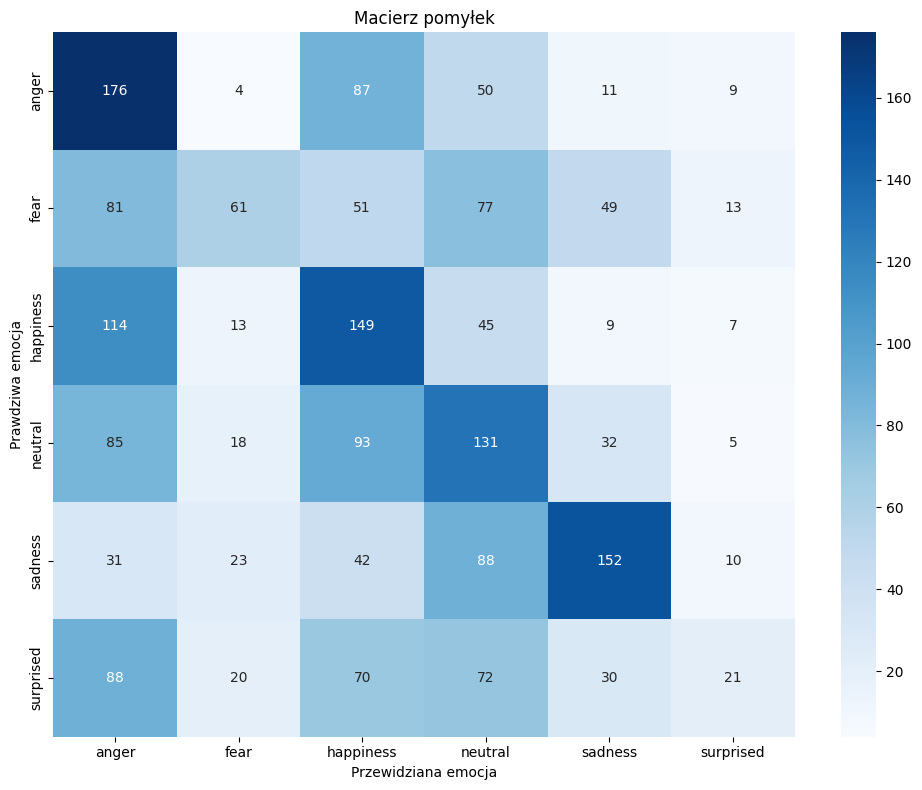

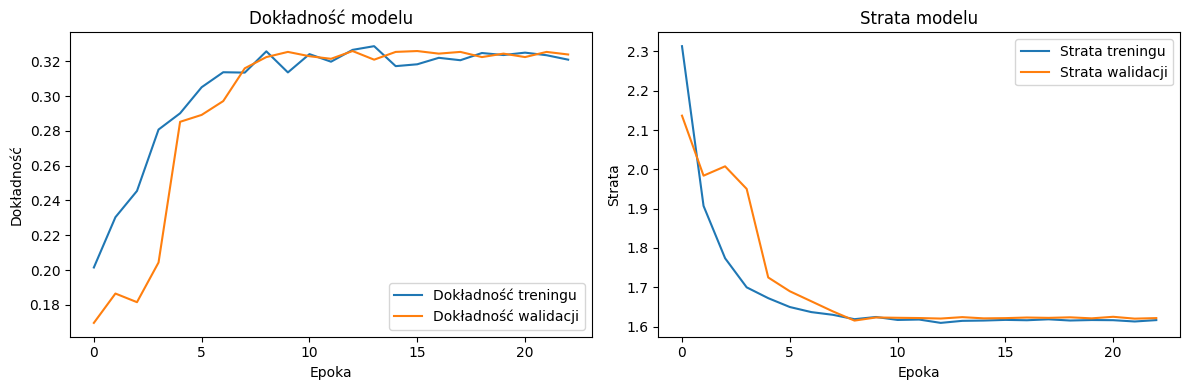

In [12]:
# Trening modelu
history = model.fit(
    [X_zcr_train, X_rms_train], y_train,
    validation_data=([X_zcr_val, X_rms_val], y_val),
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Ładowanie najlepszego modelu
try:
    best_model = tf.keras.models.load_model('best_parallel_emotion_model_augmented.keras')
    print("Wczytano najlepszy model z pliku best_parallel_emotion_model_augmented.keras")
except:
    best_model = model
    print("Używamy modelu z końca treningu")

# Ocena modelu na zbiorze testowym
test_loss, test_acc = best_model.evaluate([X_zcr_test, X_rms_test], y_test, verbose=1)
print(f"\nDokładność na zbiorze testowym: {test_acc:.4f}")

# Predykcja na zbiorze testowym
y_pred = best_model.predict([X_zcr_test, X_rms_test])
y_pred_classes = np.argmax(y_pred, axis=1)

# Raport klasyfikacji
print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred_classes))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred_classes)
print("\nMacierz pomyłek:")
print(cm)

# Obliczanie F1-score
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
print(f"\nMacro F1-score: {f1_macro:.4f}")

# Wykresy
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[k for k in emotion_labels.keys()],
            yticklabels=[k for k in emotion_labels.keys()])
plt.xlabel('Przewidziana emocja')
plt.ylabel('Prawdziwa emocja')
plt.title('Macierz pomyłek')
plt.tight_layout()
plt.savefig('parallel_confusion_matrix_augmented.png')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningu')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacji')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningu')
plt.plot(history.history['val_loss'], label='Strata walidacji')
plt.title('Strata modelu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.tight_layout()
plt.savefig('parallel_training_history_augmented.png')
plt.show()

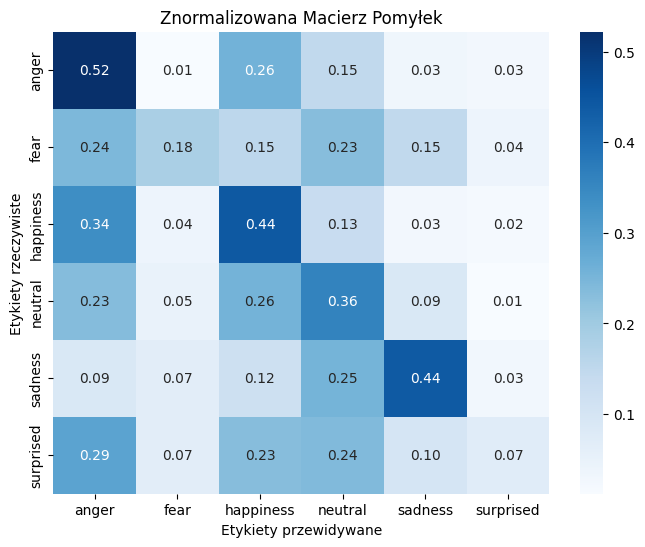

In [13]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Rysowanie macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Etykiety przewidywane')
plt.ylabel('Etykiety rzeczywiste')
plt.title('Znormalizowana Macierz Pomyłek')
plt.savefig('normalized_confusion_matrix.png', format='png', dpi=300)
plt.show()

### Zapisywanie i wizualizacja modelu

In [16]:
# Zapisanie mapowania etykiet
with open('emotion_labels_parallel_augmented.json', 'w') as f:
    json.dump(emotion_labels, f)
print(f"Zapisano mapowanie etykiet do pliku emotion_labels_parallel_augmented.json")

# Wizualizacja modelu (opcjonalnie)
try:
    tf.keras.utils.plot_model(
        model,
        to_file='parallel_model_architecture_augmented.png',
        show_shapes=True,
        show_layer_names=True
    )
    print("Zapisano architekturę modelu do pliku parallel_model_architecture_augmented.png")
except Exception as e:
    print(f"Wizualizacja architektury modelu nie powiodła się: {e}")

Zapisano mapowanie etykiet do pliku emotion_labels_parallel_augmented.json
You must install pydot (`pip install pydot`) for `plot_model` to work.
Zapisano architekturę modelu do pliku parallel_model_architecture_augmented.png


### POŁĄCZENIE PIERWOTNEGO MODELU CNN (własna sieć) z CONV1D i RNN, zastosowanie metody ensemble
Ensemble learning często prowadzi do lepszych wyników, ponieważ łączy zalety różnych architektury i cech. 

### Model CNN z wykorzystaniem spektrogramów Mel'a

In [17]:
def audio_to_mel_spectrogram(audio_array, sr=24000):
    n_fft = 1024
    hop_length = 256
    audio_array = audio_array / (np.max(np.abs(audio_array)) + 1e-10)
    pre_emphasis = np.append(audio_array[0], audio_array[1:] - 0.97 * audio_array[:-1])
    
    mel_spec = librosa.feature.melspectrogram(
        y=pre_emphasis,
        sr=sr,
        n_mels=80,
        n_fft=n_fft,
        hop_length=hop_length,
        power=2.0,
        fmax=8000
    )
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
    mel_spec_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db) + 1e-10)
    return mel_spec_norm


### PRZYGOTOWANIE DANYCH DO MODELU 1 (CNN na spektrogramach Mel)

In [18]:
mel_specs = []
mel_aug_labels = []

# Docelowy rozmiar spektrogramu
mel_target_size = (80, 200)

# Dla każdej próbki audio
for audio, sr, label in zip(audio_files, sample_rates, numeric_labels):
    # Przycinanie lub paddowanie audio do stałej długości (5 sekund)
    max_len = 5 * sr
    if len(audio) > max_len:
        start = np.random.randint(0, len(audio) - max_len)
        audio = audio[start:start + max_len]
    else:
        padding = np.zeros(max_len - len(audio))
        audio = np.concatenate([audio, padding])
    
    # Dodanie oryginalnej próbki
    mel_spec = audio_to_mel_spectrogram(audio, sr=sr)
    
    # Zmiana rozmiaru spektrogramu
    mel_spec = tf.convert_to_tensor(mel_spec, dtype=tf.float32)
    mel_spec = tf.expand_dims(mel_spec, axis=-1)
    mel_spec = tf.image.resize(mel_spec, mel_target_size)
    mel_spec = tf.squeeze(mel_spec).numpy()
    
    mel_specs.append(mel_spec)
    mel_aug_labels.append(label)
    
    # Dodanie augmentowanych próbek
    for _ in range(2):
        augmented_audio = apply_augmentation(audio, sr)
        aug_mel_spec = audio_to_mel_spectrogram(augmented_audio, sr=sr)
        
        aug_mel_spec = tf.convert_to_tensor(aug_mel_spec, dtype=tf.float32)
        aug_mel_spec = tf.expand_dims(aug_mel_spec, axis=-1)
        aug_mel_spec = tf.image.resize(aug_mel_spec, mel_target_size)
        aug_mel_spec = tf.squeeze(aug_mel_spec).numpy()
        
        mel_specs.append(aug_mel_spec)
        mel_aug_labels.append(label)

# Konwersja na numpy arrays dla CNN
X_mel = np.array(mel_specs).reshape(-1, mel_target_size[0], mel_target_size[1], 1)
y_mel = np.array(mel_aug_labels).astype('int32')

### Sprawdzenie wymiarów danych

In [20]:
# Upewniamy się, że wszystkie etykiety są spójne
assert np.array_equal(y_mel, y_features), "Etykiety dla obu typów cech są różne!"
y = y_mel  # Używamy jednego zestawu etykiet

# Wyświetlanie informacji o kształcie danych
print(f"Kształt danych X_mel dla CNN: {X_mel.shape}")
print(f"Kształt danych X_zcr dla Conv1D/RNN: {X_zcr.shape}")
print(f"Kształt danych X_rms dla Conv1D/RNN: {X_rms.shape}")
print(f"Kształt danych y (etykiety): {y.shape}")
print(f"Liczba oryginalnych próbek: {len(audio_files)}")
print(f"Liczba próbek po augmentacji: {len(y)}")

Kształt danych X_mel dla CNN: (13443, 80, 200, 1)
Kształt danych X_zcr dla Conv1D/RNN: (13443, 200, 1)
Kształt danych X_rms dla Conv1D/RNN: (13443, 200, 1)
Kształt danych y (etykiety): (13443,)
Liczba oryginalnych próbek: 4481
Liczba próbek po augmentacji: 13443


### Podział na zbiory treningowy, walidacyjny i testowy. Najpierw dzielimy indeksy, aby zapewnić spójność podziału między różnymi cechami.

In [21]:
indices = np.arange(len(y))
indices_train, indices_temp, y_train, y_temp = train_test_split(
    indices, y, test_size=0.3, random_state=42, stratify=y
)
indices_val, indices_test, y_val, y_test = train_test_split(
    indices_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Teraz dzielimy dane na podstawie indeksów
X_mel_train, X_mel_val, X_mel_test = X_mel[indices_train], X_mel[indices_val], X_mel[indices_test]
X_zcr_train, X_zcr_val, X_zcr_test = X_zcr[indices_train], X_zcr[indices_val], X_zcr[indices_test]
X_rms_train, X_rms_val, X_rms_test = X_rms[indices_train], X_rms[indices_val], X_rms[indices_test]

print(f"Rozmiar zbioru treningowego: {len(y_train)} próbek")
print(f"Rozmiar zbioru walidacyjnego: {len(y_val)} próbek")
print(f"Rozmiar zbioru testowego: {len(y_test)} próbek")

# Wyświetl rozkład klas w zbiorze treningowym
class_counts = np.bincount(y_train)
print("\nRozkład klas w zbiorze treningowym:")
for label, count in enumerate(class_counts):
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {count} próbek")

# Obliczenie wag klas dla zrównoważenia
class_weights = {}
total_samples = len(y_train)
n_classes = len(emotion_labels)
for label, count in enumerate(class_counts):
    class_weights[label] = total_samples / (n_classes * count)

print("\nWagi klas:")
for label, weight in class_weights.items():
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {weight:.4f}")


Rozmiar zbioru treningowego: 9410 próbek
Rozmiar zbioru walidacyjnego: 2016 próbek
Rozmiar zbioru testowego: 2017 próbek

Rozkład klas w zbiorze treningowym:
  anger: 1573 próbek
  fear: 1545 próbek
  happiness: 1573 próbek
  neutral: 1699 próbek
  sadness: 1615 próbek
  surprised: 1405 próbek

Wagi klas:
  anger: 0.9970
  fear: 1.0151
  happiness: 0.9970
  neutral: 0.9231
  sadness: 0.9711
  surprised: 1.1163


### DEFINICJA MODELU 1: MODEL CNN DLA SPEKTROGRAMÓW MEL

In [22]:
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### DEFINICJA MODELU ENSEMBLE

In [23]:
def create_fresh_ensemble_model(num_classes):
    """Create a new ensemble model from scratch, using the original architecture."""
    
    # CNN Branch (for Mel Spectrogram)
    mel_input = tf.keras.layers.Input(shape=(80, 200, 1), name='mel_input')
    
    x_cnn = tf.keras.layers.BatchNormalization()(mel_input)
    x_cnn = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x_cnn)
    x_cnn = tf.keras.layers.MaxPool2D((2, 2))(x_cnn)
    x_cnn = tf.keras.layers.Dropout(0.3)(x_cnn)
    
    x_cnn = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x_cnn)
    x_cnn = tf.keras.layers.MaxPool2D((2, 2))(x_cnn)
    x_cnn = tf.keras.layers.Dropout(0.4)(x_cnn)
    
    x_cnn = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x_cnn)
    x_cnn = tf.keras.layers.MaxPool2D((2, 2))(x_cnn)
    x_cnn = tf.keras.layers.Dropout(0.5)(x_cnn)
    
    x_cnn = tf.keras.layers.GlobalAveragePooling2D()(x_cnn)
    cnn_features = tf.keras.layers.Dense(128, activation='relu')(x_cnn)
    
    # Parallel Branch (for ZCR and RMS)
    zcr_input = tf.keras.layers.Input(shape=(200, 1), name='zcr_input')
    rms_input = tf.keras.layers.Input(shape=(200, 1), name='rms_input')
    
    # ZCR path
    x_zcr = tf.keras.layers.Conv1D(64, 5, activation='relu')(zcr_input)
    x_zcr = tf.keras.layers.BatchNormalization()(x_zcr)
    x_zcr = tf.keras.layers.MaxPooling1D(2)(x_zcr)
    x_zcr = tf.keras.layers.Dropout(0.3)(x_zcr)
    
    x_zcr = tf.keras.layers.Conv1D(128, 3, activation='relu')(x_zcr)
    x_zcr = tf.keras.layers.BatchNormalization()(x_zcr)
    x_zcr = tf.keras.layers.MaxPooling1D(2)(x_zcr)
    x_zcr = tf.keras.layers.Dropout(0.4)(x_zcr)
    
    x_zcr = tf.keras.layers.GlobalAveragePooling1D()(x_zcr)
    
    # RMS path
    x_rms = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(rms_input)
    x_rms = tf.keras.layers.BatchNormalization()(x_rms)
    x_rms = tf.keras.layers.Dropout(0.3)(x_rms)
    
    x_rms = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x_rms)
    x_rms = tf.keras.layers.BatchNormalization()(x_rms)
    x_rms = tf.keras.layers.Dropout(0.4)(x_rms)
    
    # Combine ZCR and RMS paths
    parallel_features = tf.keras.layers.concatenate([x_zcr, x_rms])
    parallel_features = tf.keras.layers.Dense(128, activation='relu')(parallel_features)
    
    # Combine CNN and Parallel branches
    all_features = tf.keras.layers.concatenate([cnn_features, parallel_features])
    
    # Final classification layers
    x = tf.keras.layers.Dense(256, activation='relu')(all_features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = tf.keras.Model(inputs=[mel_input, zcr_input, rms_input], outputs=output)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Funkcja zmieniająca współczynnik uczenia w zależności od epoki
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * 0.5
    elif epoch < 15:
        return lr * 0.25
    else:
        return lr * 0.1

### Trening modelu CNN

In [24]:
print("\n===== TRENING MODELU CNN DLA SPEKTROGRAMÓW MEL'a =====")

cnn_model = create_cnn_model((80, 200, 1), len(emotion_labels))
cnn_model.summary()

cnn_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_cnn_emotion_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

cnn_history = cnn_model.fit(
    X_mel_train, y_train,
    validation_data=(X_mel_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=cnn_callbacks,
    class_weight=class_weights,
    verbose=1
)

# Ładowanie najlepszego modelu CNN
try:
    cnn_model = tf.keras.models.load_model('best_cnn_emotion_model.keras')
    print("Wczytano najlepszy model CNN z pliku best_cnn_emotion_model.keras")
except:
    print("Używamy modelu CNN z końca treningu")

# Ocena modelu CNN na zbiorze testowym
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_mel_test, y_test, verbose=1)
print(f"\nDokładność modelu CNN na zbiorze testowym: {cnn_test_acc:.4f}")

# Predykcja modelu CNN na zbiorze testowym
cnn_y_pred = cnn_model.predict(X_mel_test)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis=1)

# Raport klasyfikacji dla modelu CNN
print("\nRaport klasyfikacji dla modelu CNN:")
print(classification_report(y_test, cnn_y_pred_classes))

# F1-score dla modelu CNN
cnn_f1_macro = f1_score(y_test, cnn_y_pred_classes, average='macro')
print(f"\nMacro F1-score dla modelu CNN: {cnn_f1_macro:.4f}")


===== TRENING MODELU CNN DLA SPEKTROGRAMÓW MEL =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_5                │ (None, 80, 200, 1)          │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 80, 200, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 100, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 40, 100, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 100, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,962 (429.54 KB)

 Trainable params: 109,960 (429.53 KB)

 Non-trainable params: 2 (8.00 B)

Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1725 - loss: 1.7965
Epoch 1: val_accuracy improved from -inf to 0.20883, saving model to best_cnn_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.1725 - loss: 1.7965 - val_accuracy: 0.2088 - val_loss: 1.7860 - learning_rate: 0.0010
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2122 - loss: 1.7668
Epoch 2: val_accuracy improved from 0.20883 to 0.26637, saving model to best_cnn_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.2122 - loss: 1.7668 - val_accuracy: 0.2664 - val_loss: 1.6878 - learning_rate: 0.0010
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2666 - loss: 1.6823
Epoch 3: val_accuracy improved from 0.26637 to 0.35317, saving model to best_cnn_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.2667 - loss: 1.6822 - val_accuracy: 0.3532 - val_loss: 1.5806 - learning_rate: 0.0010
Epoch 4/20
295/295 

### TRENING MODELU ENSEMBLE

In [25]:
print("\n===== TRENING MODELU ENSEMBLE =====")

ensemble_model = create_fresh_ensemble_model(len(emotion_labels))
ensemble_model.summary()

ensemble_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_ensemble_emotion_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

ensemble_history = ensemble_model.fit(
    [X_mel_train, X_zcr_train, X_rms_train], y_train,
    validation_data=([X_mel_val, X_zcr_val, X_rms_val], y_val),
    epochs=25,
    batch_size=32,
    callbacks=ensemble_callbacks,
    class_weight=class_weights,
    verbose=1
)

# Ładowanie najlepszego modelu ensemble
try:
    ensemble_model = tf.keras.models.load_model('best_ensemble_emotion_model.keras')
    print("Wczytano najlepszy model ensemble z pliku best_ensemble_emotion_model.keras")
except:
    print("Używamy modelu ensemble z końca treningu")

# Ocena modelu ensemble na zbiorze testowym
ensemble_test_loss, ensemble_test_acc = ensemble_model.evaluate([X_mel_test, X_zcr_test, X_rms_test], y_test, verbose=1)
print(f"\nDokładność modelu ensemble na zbiorze testowym: {ensemble_test_acc:.4f}")

# Predykcja modelu ensemble na zbiorze testowym
ensemble_y_pred = ensemble_model.predict([X_mel_test, X_zcr_test, X_rms_test])
ensemble_y_pred_classes = np.argmax(ensemble_y_pred, axis=1)

# Raport klasyfikacji dla modelu ensemble
print("\nRaport klasyfikacji dla modelu ensemble:")
print(classification_report(y_test, ensemble_y_pred_classes))

# Macierz pomyłek dla modelu ensemble
cm = confusion_matrix(y_test, ensemble_y_pred_classes)
print("\nMacierz pomyłek dla modelu ensemble:")
print(cm)

# F1-score dla modelu ensemble
ensemble_f1_macro = f1_score(y_test, ensemble_y_pred_classes, average='macro')
print(f"\nMacro F1-score dla modelu ensemble: {ensemble_f1_macro:.4f}")


===== TRENING MODELU ENSEMBLE =====


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mel_input (InputLayer)        │ (None, 80, 200, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 80, 200, 1)        │               4 │ mel_input[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zcr_input (InputLayer)        │ (None, 200, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 80, 200, 32)       │             320 │ batch_normalization_6[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 196, 64)           │             384 │ zcr_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 40, 100, 32)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 196, 64)           │             256 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 40, 100, 32)       │               0 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 98, 64)            │               0 │ batch_normalization_7[0][… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rms_input (InputLayer)        │ (None, 200, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 40, 100, 64)       │          18,496 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 98, 64)            │               0 │ max_pooling1d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_2               │ (None, 200, 128)          │          33,792 │ rms_input[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 20, 50, 64)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 369,930 (1.41 MB)

 Trainable params: 368,520 (1.41 MB)

 Non-trainable params: 1,410 (5.51 KB)

Epoch 1/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1977 - loss: 2.4030
Epoch 1: val_accuracy improved from -inf to 0.16766, saving model to best_ensemble_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 834s 3s/step - accuracy: 0.1977 - loss: 2.4022 - val_accuracy: 0.1677 - val_loss: 1.9211 - learning_rate: 5.0000e-04
Epoch 2/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2250 - loss: 1.9359
Epoch 2: val_accuracy improved from 0.16766 to 0.21230, saving model to best_ensemble_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 789s 3s/step - accuracy: 0.2250 - loss: 1.9357 - val_accuracy: 0.2123 - val_loss: 1.9687 - learning_rate: 5.0000e-04
Epoch 3/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2535 - loss: 1.8211
Epoch 3: val_accuracy did not improve from 0.21230
295/295 ━━━━━━━━━━━━━━━━━━━━ 795s 3s/step - accuracy: 0.2536 - loss: 1.8210 - val_accuracy: 0.2093 - val_loss: 1.9930 - learning_rate: 5.0000e-04
Epoch 4/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/s

### PORÓWNANIE MODELI


===== PORÓWNANIE MODELI =====
Dokładność modelu CNN:        0.4680
Dokładność modelu równoległego: 0.3421
Dokładność modelu ensemble:   0.3659
F1-score modelu CNN:        0.4376
F1-score modelu równoległego: 0.3199
F1-score modelu ensemble:   0.3123


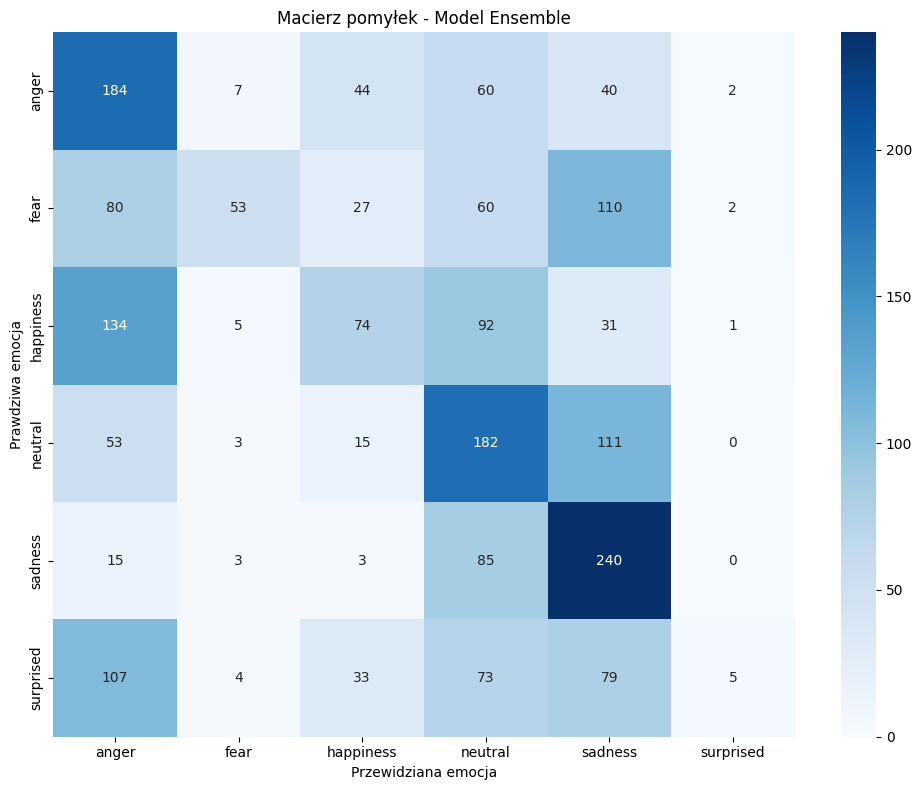

<module 'matplotlib.pyplot' from 'C:\\Users\\Dell\\anaconda3\\envs\\emocje_dl\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 1500x1000 with 0 Axes>

In [27]:
print("\n===== PORÓWNANIE MODELI =====")
print(f"Dokładność modelu CNN:        {cnn_test_acc:.4f}")
print(f"Dokładność modelu równoległego: {test_acc:.4f}")
print(f"Dokładność modelu ensemble:   {ensemble_test_acc:.4f}")
print(f"F1-score modelu CNN:        {cnn_f1_macro:.4f}")
print(f"F1-score modelu równoległego: {f1_macro:.4f}")
print(f"F1-score modelu ensemble:   {ensemble_f1_macro:.4f}")

# --------------------------------
# WIZUALIZACJE
# --------------------------------
# Macierz pomyłek dla modelu ensemble
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[k for k in emotion_labels.keys()],
            yticklabels=[k for k in emotion_labels.keys()])
plt.xlabel('Przewidziana emocja')
plt.ylabel('Prawdziwa emocja')
plt.title('Macierz pomyłek - Model Ensemble')
plt.tight_layout()
plt.savefig('ensemble_confusion_matrix.png')
plt.show()

# Wykresy historii treningu dla wszystkich modeli
plt.figure(figsize=(15, 10))

# Dokładność
plt

#### PODSUMOWANIE  
Model sieci konwolucyjnych CNN radzi sobie lepiej niż równolegle działające warstwy konwolucyjne 1D i sieci rekurencyjne.  
Model ensemble: połączenie modelu CNN z modelem równoległym daje nieco lepsze wyniki niż sam model "równoległy", aczkolwiek wszystkie modele klasyfikują emocje na niezbyt zadowalającym poziomie. Nadal najlepszym modelem jest ResNET. 
